In [79]:
import matplotlib.pyplot as plt
import networkx as nx

class Vertex:
    def __init__(self, label, angle_type='F'):
        self.label = label
        self.angle_type = angle_type
        self.edges = {}

class Edge:
    def __init__(self, start, end, weight=1, direction=None):
        self.start = start
        self.end = end
        self.weight = weight
        self.length = weight
        self.direction = direction

class WeightedGraph:
    def __init__(self):
        self.vertices = {}
        self.first_edge_points = None
        
    def add_vertex(self, key, angle_type='F'):
        if key not in self.vertices:
            self.vertices[key] = Vertex(key, angle_type)

    def add_edge(self, start, end, weight=1, direction=None):
        if start in self.vertices and end in self.vertices:
            edge = Edge(start, end, weight, direction)
            self.vertices[start].edges[end] = edge
            if self.first_edge_points is None:
                self.first_edge_points = (start, end)

    def update_vertex_angle_type(self, vertex_key, new_angle_type):
        if vertex_key in self.vertices:
            self.vertices[vertex_key].angle_type = new_angle_type

    def update_edge(self, start, end, new_length=None, new_direction=None):
        if start in self.vertices and end in self.vertices[start].edges:
            edge = self.vertices[start].edges[end]
            if new_length is not None:
                edge.length = new_length
            if new_direction is not None:
                edge.direction = new_direction

    def change_edge_length(self, start, end, new_length):
        self.update_edge(start, end, new_length=new_length)

    def remove_vertex(self, key):
        if key in self.vertices:
            del self.vertices[key]
            for vertex in self.vertices.values():
                if key in vertex.edges:
                    del vertex.edges[key]

    def get_edge(self, start, end):
        if start in self.vertices and end in self.vertices[start].edges:
            return self.vertices[start].edges[end]
        return None

    def calculate_positions(self, start_key=None):
        if start_key is None and self.first_edge_points:
            start_key = self.first_edge_points[0]
        pos = {start_key: (0, 0)}

        def place_vertex(vertex_key, x, y):
            pos[vertex_key] = (x, y)
            for end_key, edge in self.vertices[vertex_key].edges.items():
                if end_key in self.vertices and end_key not in pos:
                    if edge.direction == 'E':
                        new_x = x + max(edge.length, edge.weight)
                        place_vertex(end_key, new_x, y)
                    elif edge.direction == 'S':
                        new_y = y - max(edge.length, edge.weight)
                        place_vertex(end_key, x, new_y)
                    elif edge.direction == 'W':
                        new_x = x - max(edge.length, edge.weight)
                        place_vertex(end_key, new_x, y)
                    elif edge.direction == 'N':
                        new_y = y + max(edge.length, edge.weight)
                        place_vertex(end_key, x, new_y)

            if len(pos) == len(self.vertices):
                x_last, y_last = pos[vertex_key]
                if vertex_key != start_key:
                    for end_key, edge in self.vertices[vertex_key].edges.items():
                        if end_key in pos:
                            if edge.direction in ['N', 'S'] and x_last != pos[end_key][0]:
                                pos[vertex_key] = (pos[end_key][0], y_last)
                            elif edge.direction in ['E', 'W'] and y_last != pos[end_key][1]:
                                pos[vertex_key] = (x_last, pos[end_key][1])

        if start_key in self.vertices:
            place_vertex(start_key, 0, 0)
        return pos

    def draw_edges(self, pos):
        for vertex_key in self.vertices:
            if vertex_key not in pos:
                continue
            for end_key, edge in self.vertices[vertex_key].edges.items():
                if end_key in pos:
                    x_start, y_start = pos[vertex_key]
                    x_end, y_end = pos[end_key]
                    plt.plot([x_start, x_end], [y_start, y_end], 'k-')

    def print_graph(self):
        for key, vertex in self.vertices.items():
            edges_info = ', '.join([f"{end} (weight: {edge.weight}, {edge.direction})" for end, edge in vertex.edges.items()])
            print(f"Vertex: {key}, Angle Type: {vertex.angle_type}, Edges: {edges_info if edges_info else 'No edges'}")

    def draw_graph(self):
        pos = self.calculate_positions()
        x_values = [pos[key][0] for key in pos]
        y_values = [pos[key][1] for key in pos]
        min_x, max_x = min(x_values), max(x_values)
        min_y, max_y = min(y_values), max(y_values)
        mid_x = (min_x + max_x) / 2
        mid_y = (min_y + max_y) / 2
        width = max_x - min_x + 2
        height = max_y - min_y + 2

        plt.figure(figsize=(8, 8))
        self.draw_edges(pos)

        for key, vertex in self.vertices.items():
            if key in pos:
                plt.scatter(*pos[key], s=700, c='skyblue')
                plt.text(pos[key][0], pos[key][1], f"{vertex.label} ({vertex.angle_type})", fontsize=12, ha='center', va='center')

        plt.grid(True)
        plt.xlim(mid_x - width / 2, mid_x + width / 2)
        plt.ylim(mid_y - height / 2, mid_y + height / 2)
        plt.xticks(range(int(mid_x - width / 2), int(mid_x + width / 2) + 1))
        plt.yticks(range(int(mid_y - height / 2), int(mid_y + height / 2) + 1))
        plt.gca().set_aspect('equal', adjustable='box')

        for vertex_key in self.vertices:
            if vertex_key in pos:
                for end_key in self.vertices[vertex_key].edges:
                    if end_key in pos:
                        edge_length = self.vertices[vertex_key].edges[end_key].length
                        plt.text((pos[vertex_key][0] + pos[end_key][0]) / 2, (pos[vertex_key][1] + pos[end_key][1]) / 2, str(edge_length), fontsize=10, ha='center')

        plt.show()

    def detect_rotation_direction(self):
        rotations = {'Clockwise': 0, 'Anticlockwise': 0}
        direction_map = {'N': 0, 'E': 1, 'S': 2, 'W': 3}
        
        for vertex_key, vertex in self.vertices.items():
            if vertex.angle_type not in ['R', 'C']:
                continue
                
            incoming_edges = []
            outgoing_edges = []
            
            for other_vertex, other_edges in self.vertices.items():
                for end, edge in other_edges.edges.items():
                    if end == vertex_key:
                        incoming_edges.append(edge)
                    if other_vertex == vertex_key and end in self.vertices:
                        outgoing_edges.append(edge)
            
            if not incoming_edges or not outgoing_edges:
                continue
                
            for in_edge in incoming_edges:
                for out_edge in outgoing_edges:
                    if in_edge.direction and out_edge.direction:
                        in_dir = direction_map[in_edge.direction]
                        out_dir = direction_map[out_edge.direction]
                        
                        if vertex.angle_type == 'R':
                            if (out_dir - in_dir) % 4 == 1:
                                rotations['Clockwise'] += 1
                            elif (out_dir - in_dir) % 4 == 3:
                                rotations['Anticlockwise'] += 1
                        elif vertex.angle_type == 'C':
                            if (out_dir - in_dir) % 4 == 3:
                                rotations['Clockwise'] += 1
                            elif (out_dir - in_dir) % 4 == 1:
                                rotations['Anticlockwise'] += 1
        
        return 'Clockwise' if rotations['Clockwise'] > rotations['Anticlockwise'] else 'Anticlockwise'

    def get_graph_string(self):
        visited = set()
        path = []
        
        def dfs(vertex_key):
            if vertex_key in visited:
                return
            visited.add(vertex_key)
            path.append(self.vertices[vertex_key].angle_type)
            for end_key in self.vertices[vertex_key].edges:
                if end_key not in visited:
                    dfs(end_key)
        
        if self.first_edge_points:
            dfs(self.first_edge_points[0])
        elif self.vertices:
            dfs(next(iter(self.vertices)))
            
        return ''.join(path)

    def calculate_rotation_value(self):
        graph_string = self.get_graph_string()
        rotation_value = 0
        for char in graph_string:
            if char == 'R':
                rotation_value += 1
            elif char == 'C':
                rotation_value -= 1
        return rotation_value
    def create_graph_with_rotation(self, vertices_info, rotation='Clockwise', default_direction='N'):
        def generate_label(index):
            def int_to_base26(n):
                result = ""
                while n >= 0:
                    result = chr(65 + (n % 26)) + result
                    n = n // 26 - 1
                return result
            return int_to_base26(index)

        if isinstance(vertices_info, str):
            vertices_info = [(generate_label(i), char if char in ['R', 'C'] else 'F', 1) 
                            for i, char in enumerate(vertices_info)]

        clockwise_sequence = ['N', 'E', 'S', 'W']
        anticlockwise_sequence = ['N', 'W', 'S', 'E']
        rotation_sequence = clockwise_sequence if rotation == 'Clockwise' else anticlockwise_sequence

        # Add all vertices
        for vertex_info in vertices_info:
            label, angle_type = vertex_info[:2]
            self.add_vertex(label, angle_type)

        if len(vertices_info) > 0:
            # Add explicit edge between the first and second points
            first_vertex = vertices_info[0]
            second_vertex = vertices_info[1] if len(vertices_info) > 1 else None
            self.add_edge(first_vertex[0], second_vertex[0], weight=1, direction=default_direction)

        # Add remaining edges and determine directions
        previous_direction = default_direction
        for i in range(len(vertices_info) - 1):
            current_vertex = vertices_info[i]
            next_vertex = vertices_info[i + 1]
            current_label = current_vertex[0]
            current_angle_type = current_vertex[1]

            # Determine direction based on angle type
            if current_angle_type == 'F':
                edge_direction = previous_direction
            else:
                rotation_index = rotation_sequence.index(previous_direction)
                if current_angle_type == 'R':
                    edge_direction = rotation_sequence[(rotation_index + 1) % 4]
                elif current_angle_type == 'C':
                    edge_direction = rotation_sequence[(rotation_index - 1) % 4]

            # Add edge and update direction
            self.add_edge(current_label, next_vertex[0], weight=1, direction=edge_direction)
            previous_direction = edge_direction

        # Connect the last vertex back to the first
        if len(vertices_info) > 1:
            last_vertex = vertices_info[-1]
            first_vertex = vertices_info[0]
            last_angle_type = last_vertex[1]
            if last_angle_type == 'F':
                edge_direction = previous_direction
            else:
                rotation_index = rotation_sequence.index(previous_direction)
                if last_angle_type == 'R':
                    edge_direction = rotation_sequence[(rotation_index + 1) % 4]
                elif last_angle_type == 'C':
                    edge_direction = rotation_sequence[(rotation_index - 1) % 4]
            
            self.add_edge(last_vertex[0], first_vertex[0], weight=1, direction=edge_direction)

        return self.detect_rotation_direction()
    def find_path(self, u, v):
        # Assuming you have a method to find the path from u to v (excluding v itself)
        # This will implement the path-finding logic between u and v
        path = []
        visited = set()
        stack = [u]

        while stack:
            current = stack.pop()
            if current == v:
                break
            if current not in visited:
                visited.add(current)
                path.append(current)
                for neighbor in self.vertices[current].edges:
                    if neighbor not in visited:
                        stack.append(neighbor)

        return path

    def rot(self, u, v):
        # Get the path between u and v (excluding v)
        path = self.find_path(u, v)
        score = 0

        for vertex_key in path:
            vertex = self.vertices[vertex_key]
            
            # Calculate the degree of the vertex (sum of incoming and outgoing edges)
            degree = len(vertex.edges) + sum(1 for other_vertex in self.vertices.values() if vertex_key in other_vertex.edges)
            
            if vertex.angle_type == 'C':
                score += 1
            if vertex.angle_type == 'R' and degree == 1:
                score -= 2
            elif degree == 1:
                score -= 1

        return score

    def find_kitty_corners_first(self):
        kitty_corners = set()

        # Find all reflex vertices
        reflex_vertices = [key for key, vertex in self.vertices.items() if vertex.angle_type == 'R']

        # Check all pairs of reflex vertices
        for i in range(len(reflex_vertices)):
            for j in range(i + 1, len(reflex_vertices)):
                u = reflex_vertices[i]
                v = reflex_vertices[j]

                # Check if u and v are kitty corners
                if self.rot(u, v) == 2 or self.rot(v, u) == 2:
                    kitty_corners.add(u)
                    kitty_corners.add(v)

        return kitty_corners
    



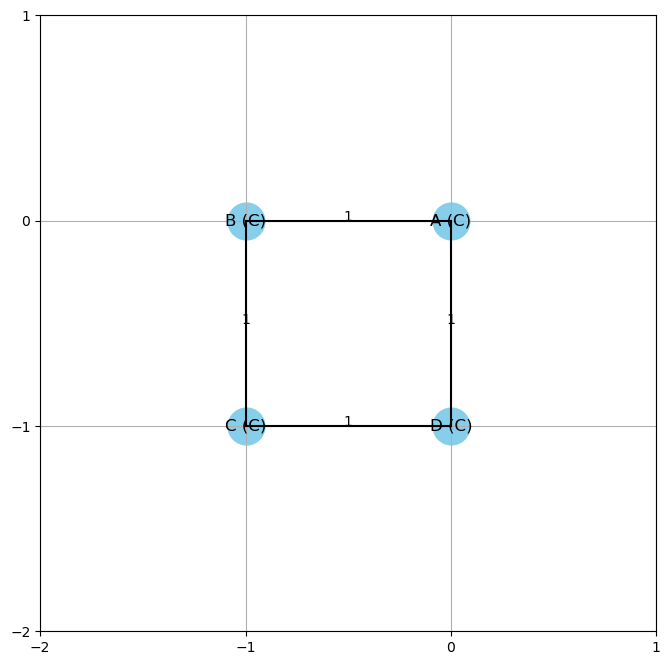

Clockwise
CCCC
-4
set()


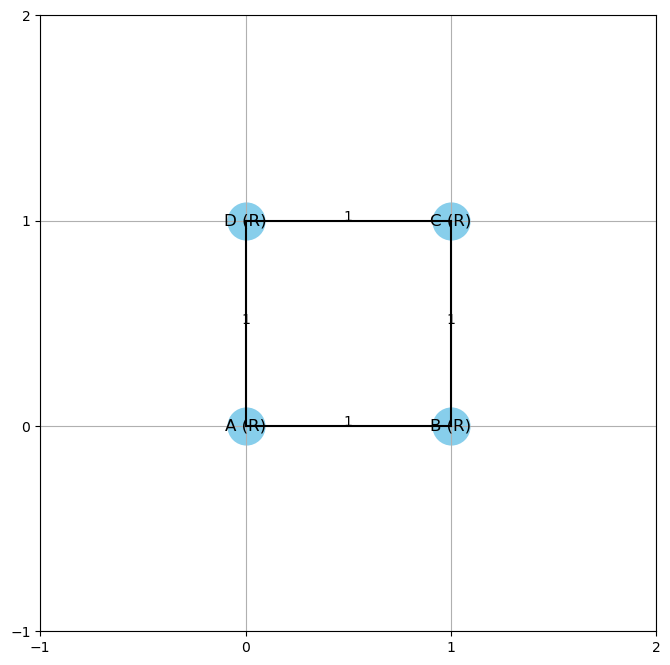

Anticlockwise
set()


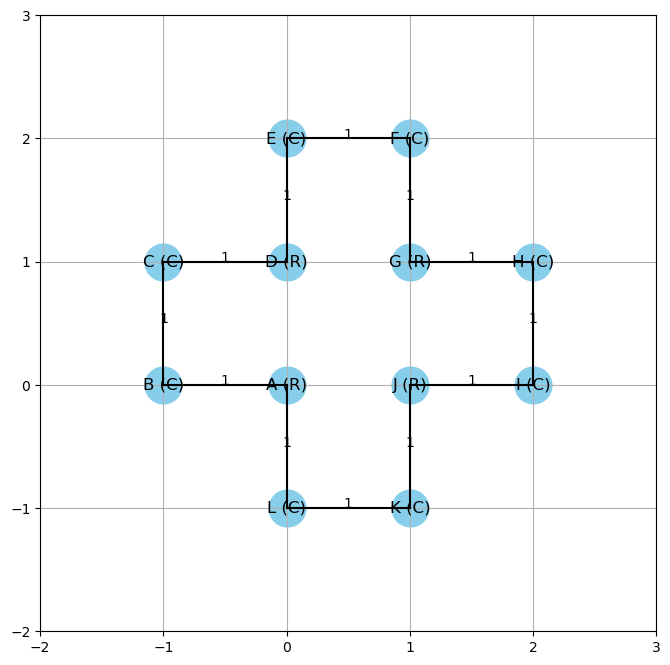

Anticlockwise
RCCRCCRCCRCC
-4
{'A', 'D', 'G', 'J'}


In [80]:
wg = WeightedGraph()
wg.create_graph_with_rotation('CCCC', 'Clockwise')
wg.draw_graph()
print(wg.detect_rotation_direction())
print(wg.get_graph_string())
print(wg.calculate_rotation_value())
print(wg.find_kitty_corners_first())

wg = WeightedGraph()
wg.add_vertex('A', 'R')
wg.add_vertex('B', 'R')
wg.add_vertex('C', 'R')
wg.add_vertex('D', 'R')
wg.add_edge('A', 'B', 1, 'E')
wg.add_edge('B', 'C', 1, 'N')
wg.add_edge('C', 'D', 1, 'W')
wg.add_edge('D', 'A', 1, 'S')
wg.draw_graph()
print(wg.detect_rotation_direction())
print(wg.find_kitty_corners_first())

tg = WeightedGraph()
tg.create_graph_with_rotation('RCCRCCRCCRCC', 'AntiClockwise')
tg.draw_graph()
print(tg.detect_rotation_direction())
print(tg.get_graph_string())
print(tg.calculate_rotation_value())
print(tg.find_kitty_corners_first())



[['A', 'B', 'C', 'D']]


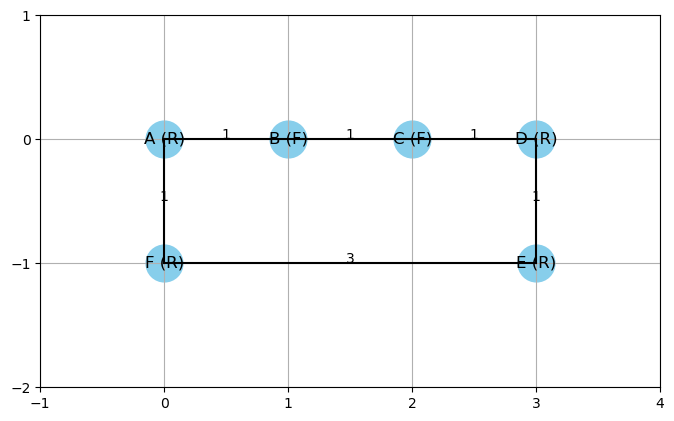

Vertex: A, Angle Type: R, Edges: B (weight: 1, E)
Vertex: B, Angle Type: F, Edges: C (weight: 1, E)
Vertex: C, Angle Type: F, Edges: D (weight: 1, E)
Vertex: D, Angle Type: R, Edges: E (weight: 1, S)
Vertex: E, Angle Type: R, Edges: F (weight: 3, W)
Vertex: F, Angle Type: R, Edges: A (weight: 1, N)
Vertex: A, Angle Type: R, Edges: D (weight: 3, E)
Vertex: D, Angle Type: R, Edges: E (weight: 1, S)
Vertex: E, Angle Type: R, Edges: F (weight: 3, W)
Vertex: F, Angle Type: R, Edges: A (weight: 1, N)


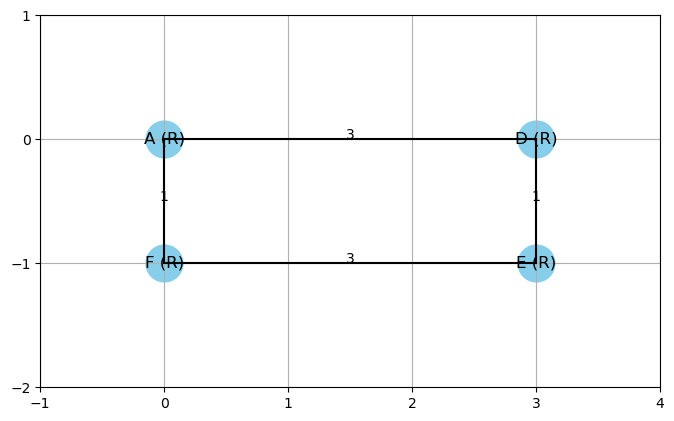

In [91]:
def list_all_paths_with_F_angle(wg):
    def find_paths(start, end, path=None, paths=None):
        if path is None:
            path = []
        if paths is None:
            paths = []
        path = path + [start]
        if start == end:
            if len(path) >= 3:
                if all(wg.vertices[v].angle_type == 'F' for v in path[1:-1]):
                    paths.append(path)
            return paths
        for neighbor in wg.vertices[start].edges.keys():
            if neighbor not in path:
                find_paths(neighbor, end, path, paths)
        return paths

    all_paths = []
    for start in wg.vertices.keys():
        if wg.vertices[start].angle_type != 'F':
            for end in wg.vertices.keys():
                if start != end and wg.vertices[end].angle_type != 'F':
                    paths = find_paths(start, end)
                    all_paths.extend(paths)
    return all_paths
    


def reduction1(wg):
    paths = list_all_paths_with_F_angle(wg)

    for path in paths:
        if len(path) < 3:
            continue
        
        start = path[0]
        end = path[-1]
        
        total_weight = sum(wg.vertices[path[i]].edges[path[i + 1]].weight for i in range(len(path) - 1))
        
        direction = wg.vertices[path[0]].edges[path[1]].direction if path[1] in wg.vertices[path[0]].edges else None
        wg.add_edge(start, end, total_weight, direction)

        for vertex in path[1:-1]:
            wg.remove_vertex(vertex)
                

wg = WeightedGraph()

wg.add_vertex('A',  'R')
wg.add_vertex('B', 'F')
wg.add_vertex('C', 'F')
wg.add_vertex('D', 'R')
wg.add_vertex('E', 'R')
wg.add_vertex('F', 'R')

wg.add_edge('A','B',1,'E')
wg.add_edge('B','C',1,'E')
wg.add_edge('C','D',1,'E')
wg.add_edge('D','E',1,'S')
wg.add_edge('E','F',3,'W')
wg.add_edge('F','A',1,'N')


print(list_all_paths_with_F_angle(wg))
wg.draw_graph()
wg.print_graph()
reduction1(wg)

wg.print_graph()
wg.draw_graph()






In [37]:
def get_all_adjacent_edges(graph):
    adjacent_edges = []
    for vertex_key, vertex in graph.vertices.items():
        for end_key, edge in vertex.edges.items():
            adjacent_edges.append((vertex_key, end_key, edge.weight, edge.direction))
    return adjacent_edges


def get_adjacent_edge_pairs(adjacent_edges):
    n = len(adjacent_edges)
    if n < 2:
        return []

    edge_pairs = [(adjacent_edges[i], adjacent_edges[(i + 1) % n]) for i in range(n)]
    return edge_pairs



print(get_all_adjacent_edges(wg))
print(get_adjacent_edge_pairs(get_all_adjacent_edges(wg)))


[('A', 'B', 1, 'E'), ('B', 'C', 1, 'N'), ('C', 'D', 1, 'W'), ('D', 'A', 1, 'S')]
[(('A', 'B', 1, 'E'), ('B', 'C', 1, 'N')), (('B', 'C', 1, 'N'), ('C', 'D', 1, 'W')), (('C', 'D', 1, 'W'), ('D', 'A', 1, 'S')), (('D', 'A', 1, 'S'), ('A', 'B', 1, 'E'))]


In [93]:
def determine_rotation_direction(graph):
    clock=0
    anti=0
    for vertex_key, vertex in graph.vertices.items():
        if vertex.angle_type=='R':
            clock+=1
        if vertex.angle_type=='C':
            anti+=1
    if clock>anti:
        return "Clockwise"
    else:
        return "Counterclockwise"

    



print(determine_rotation_direction(wg))

Clockwise


Counterclockwise
Vertex: A, Angle Type: C, Edges: B (weight: 1, E)
Vertex: B, Angle Type: F, Edges: C (weight: 1, E)
Vertex: C, Angle Type: C, Edges: D (weight: 1, N)
Vertex: D, Angle Type: C, Edges: E (weight: 1, W)
Vertex: E, Angle Type: R, Edges: F (weight: 2, N)
Vertex: F, Angle Type: C, Edges: G (weight: 1, W)
Vertex: G, Angle Type: F, Edges: H (weight: 1, W)
Vertex: H, Angle Type: F, Edges: I (weight: 1, W)
Vertex: I, Angle Type: C, Edges: J (weight: 1, S)
Vertex: J, Angle Type: C, Edges: K (weight: 1, E)
Vertex: K, Angle Type: R, Edges: L (weight: 1, S)
Vertex: L, Angle Type: C, Edges: M (weight: 1, E)
Vertex: M, Angle Type: R, Edges: A (weight: 1, S)


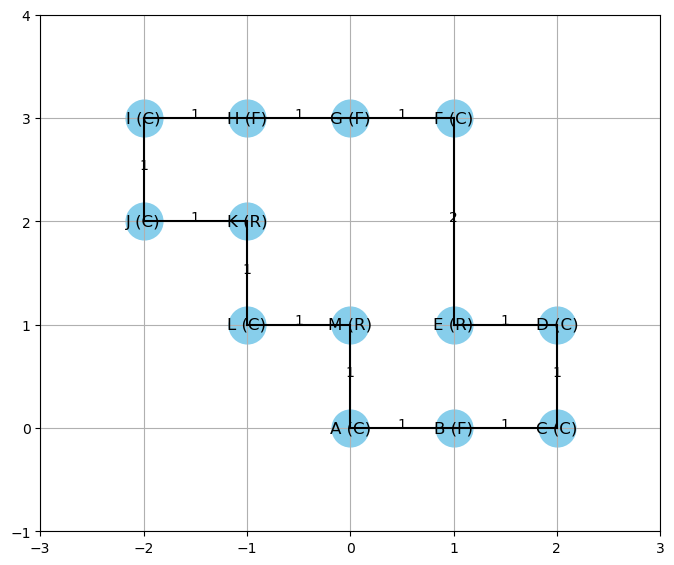

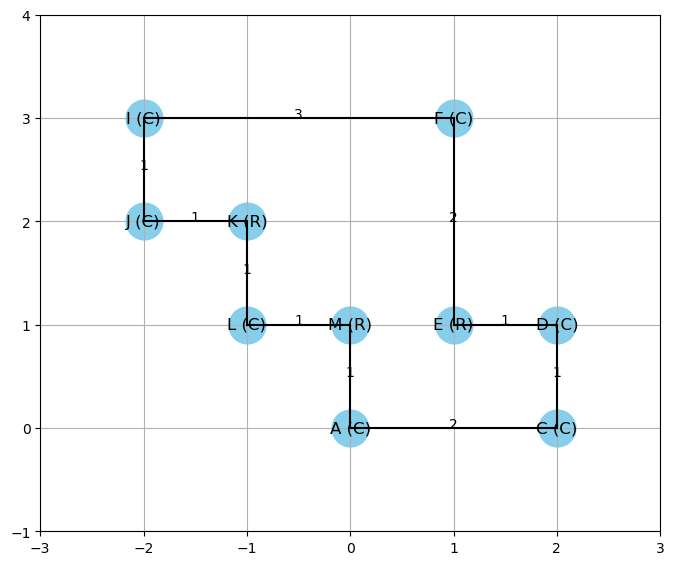

In [94]:
wg= WeightedGraph()
wg.add_vertex('A', 'C')
wg.add_vertex('B', 'F')
wg.add_vertex('C', 'C')
wg.add_vertex('D', 'C')
wg.add_vertex('E', 'R')
wg.add_vertex('F', 'C')
wg.add_vertex('G', 'F')
wg.add_vertex('H', 'F')
wg.add_vertex('I', 'C')
wg.add_vertex('J', 'C')
wg.add_vertex('K', 'R')
wg.add_vertex('L', 'C')
wg.add_vertex('M', 'R')

wg.add_edge('A','B',1,'E')
wg.add_edge('B','C',1,'E')
wg.add_edge('C','D',1,'N')
wg.add_edge('D','E',1,'W')
wg.add_edge('E','F',2,'N')
wg.add_edge('F','G',1,'W')
wg.add_edge('G','H',1,'W')
wg.add_edge('H','I',1,'W')
wg.add_edge('I','J',1,'S')
wg.add_edge('J','K',1,'E')
wg.add_edge('K','L',1,'S')
wg.add_edge('L','M',1,'E')
wg.add_edge('M','A',1,'S')


print(determine_rotation_direction(wg))
wg.print_graph()
wg.draw_graph()
reduction1(wg)
wg.draw_graph()




In [95]:
def identify_kitty_corners(graph):
    kitty_corners = [key for key, vertex in graph.vertices.items() if vertex.angle_type == 'R']
    return kitty_corners

print(identify_kitty_corners(wg))

['E', 'K', 'M']


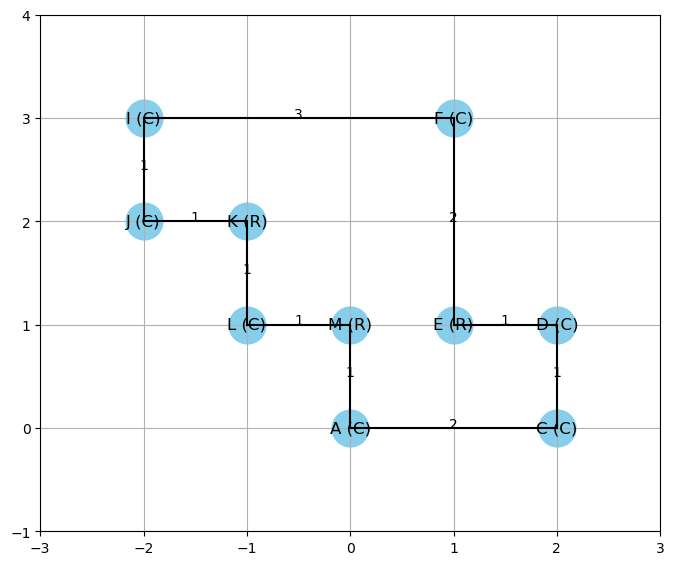

[['J', 'K', 'L', 'M', 'A']]


In [96]:
def find_paths_with_rcr(graph):
    def dfs(current_vertex, path):
        if len(path) == 5:
            if (len(path) == 5 and
                graph.vertices[path[1]].angle_type == 'R' and
                graph.vertices[path[2]].angle_type == 'C' and
                graph.vertices[path[3]].angle_type == 'R'):
                paths.append(path[:])
            return
        
        if current_vertex in graph.vertices:
            for neighbor in graph.vertices[current_vertex].edges:
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()

    paths = []
    for vertex in graph.vertices:
        dfs(vertex, [vertex])
    return paths





wg.draw_graph()
print(find_paths_with_rcr(wg))

paths=find_paths_with_rcr(wg)



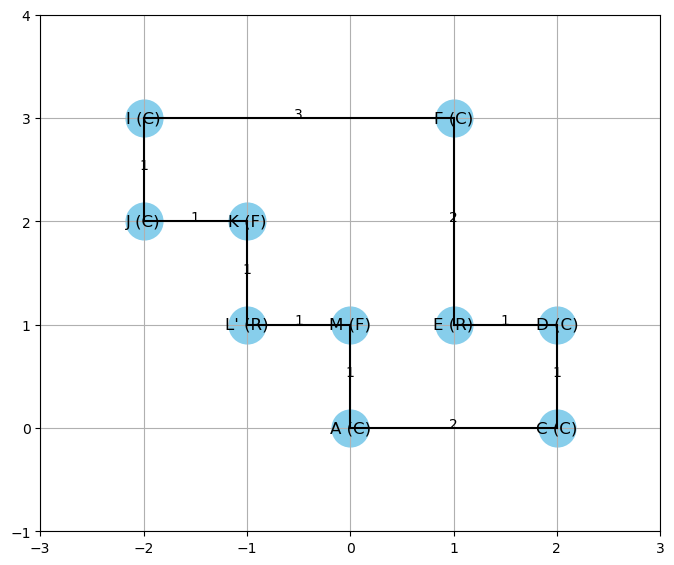

In [97]:
def rename_middle_and_update_neighbors(graph, paths):
    for path in paths:
        middle_index = 2  
        middle_vertex = path[middle_index]
        
        new_label = f"{middle_vertex}'"
        graph.update_vertex_angle_type(path[middle_index-1], 'F')  
        graph.update_vertex_angle_type(path[middle_index], 'R')
        graph.update_vertex_angle_type(path[middle_index+1], 'F')  

        
        
        graph.vertices[middle_vertex].label = new_label
        
        
        



rename_middle_and_update_neighbors(wg,paths)

wg.draw_graph()



Counterclockwise
Vertex: A, Angle Type: C, Edges: B (weight: 1, E)
Vertex: B, Angle Type: F, Edges: C (weight: 1, E)
Vertex: C, Angle Type: C, Edges: D (weight: 1, N)
Vertex: D, Angle Type: C, Edges: E (weight: 1, W)
Vertex: E, Angle Type: R, Edges: F (weight: 2, N)
Vertex: F, Angle Type: C, Edges: G (weight: 1, W)
Vertex: G, Angle Type: F, Edges: H (weight: 1, W)
Vertex: H, Angle Type: F, Edges: I (weight: 1, W)
Vertex: I, Angle Type: C, Edges: J (weight: 1, S)
Vertex: J, Angle Type: C, Edges: K (weight: 1, E)
Vertex: K, Angle Type: R, Edges: L (weight: 1, S)
Vertex: L, Angle Type: C, Edges: M (weight: 1, E)
Vertex: M, Angle Type: R, Edges: A (weight: 1, S)


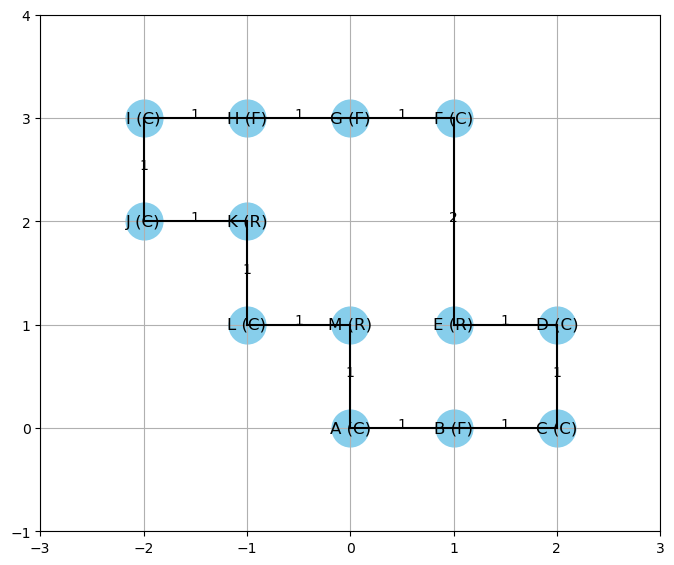

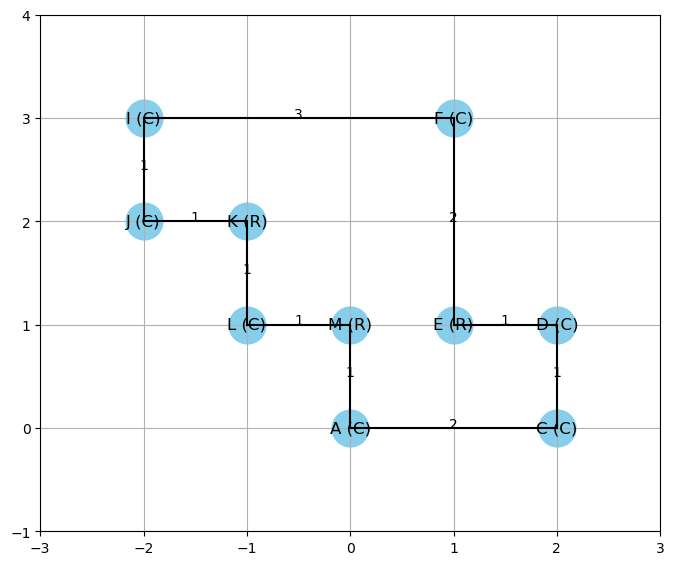

In [98]:
wg= WeightedGraph()
wg.add_vertex('A', 'C')
wg.add_vertex('B', 'F')
wg.add_vertex('C', 'C')
wg.add_vertex('D', 'C')
wg.add_vertex('E', 'R')
wg.add_vertex('F', 'C')
wg.add_vertex('G', 'F')
wg.add_vertex('H', 'F')
wg.add_vertex('I', 'C')
wg.add_vertex('J', 'C')
wg.add_vertex('K', 'R')
wg.add_vertex('L', 'C')
wg.add_vertex('M', 'R')

wg.add_edge('A','B',1,'E')
wg.add_edge('B','C',1,'E')
wg.add_edge('C','D',1,'N')
wg.add_edge('D','E',1,'W')
wg.add_edge('E','F',2,'N')
wg.add_edge('F','G',1,'W')
wg.add_edge('G','H',1,'W')
wg.add_edge('H','I',1,'W')
wg.add_edge('I','J',1,'S')
wg.add_edge('J','K',1,'E')
wg.add_edge('K','L',1,'S')
wg.add_edge('L','M',1,'E')
wg.add_edge('M','A',1,'S')


print(determine_rotation_direction(wg))
wg.print_graph()
wg.draw_graph()
reduction1(wg)
wg.draw_graph()




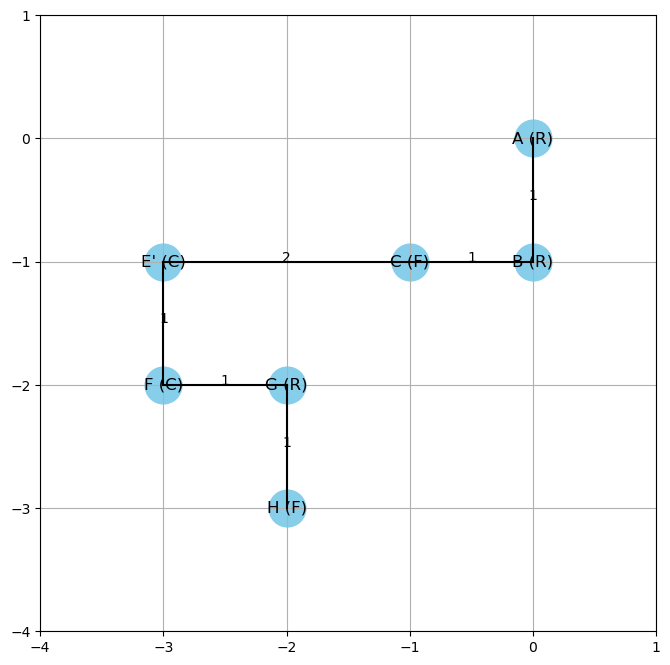

In [107]:
def swap_edge_properties(edge1, edge2):
    edge1_weight = edge1.weight
    edge1_direction = edge1.direction
    edge1_length = edge1.length
    
    edge2_weight = edge2.weight
    edge2_direction = edge2.direction
    edge2_length = edge2.length

    edge1.weight = edge2_weight
    edge1.direction = edge2_direction
    edge1.length = edge2_length
    
    edge2.weight = edge1_weight
    edge2.direction = edge1_direction
    edge2.length = edge1_length

def reduction_2(graph):
    paths = find_paths_with_rcr(graph)
    rename_middle_and_update_neighbors(graph, paths)
    
    for path in paths:
        middle_index = 2
        u2 = path[middle_index - 1]
        u3 = path[middle_index]
        u4 = path[middle_index + 1]
        edge_u2_u3 = graph.vertices[u2].edges[u3]
        edge_u3_u4 = graph.vertices[u3].edges[u4]
        
        swap_edge_properties(edge_u2_u3, edge_u3_u4)

    
reduction_2(wg)
wg.draw_graph()

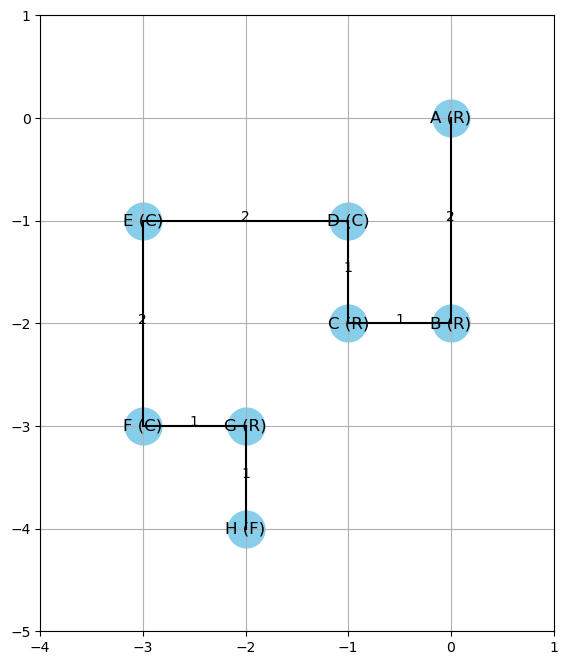

[['A', 'B', 'C', 'D', 'E', 'F', 'G']]


In [108]:
def find_paths_with_rccc(graph):
    def dfs(current_vertex, path):
        if len(path) == 7:
            if (len(path) == 7 and
                graph.vertices[path[2]].angle_type == 'R' and
                graph.vertices[path[3]].angle_type == 'C' and
                graph.vertices[path[4]].angle_type == 'C' and
                graph.vertices[path[5]].angle_type == 'C'
                ):
                paths.append(path[:])
            return
        
        if current_vertex in graph.vertices:
            for neighbor in graph.vertices[current_vertex].edges:
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()

    paths = []
    for vertex in graph.vertices:
        dfs(vertex, [vertex])
    return paths





wg= WeightedGraph()

wg.add_vertex('A', 'R')
wg.add_vertex('B', 'R')
wg.add_vertex('C', 'R')
wg.add_vertex('D', 'C')
wg.add_vertex('E', 'C')
wg.add_vertex('F', 'C')
wg.add_vertex('G', 'R')
wg.add_vertex('H', 'F')

wg.add_edge('A','B',2,'S')
wg.add_edge('B','C',1,'W')
wg.add_edge('C','D',1,'N')
wg.add_edge('D','E',2,'W')
wg.add_edge('E','F',2,'S')
wg.add_edge('F','G',1,'E')
wg.add_edge('G','H',1,'S')

wg.draw_graph()

print(find_paths_with_rccc(wg))





[['A', 'B', 'C', 'D', 'E', 'F', 'G']]
W
2
S
2
1


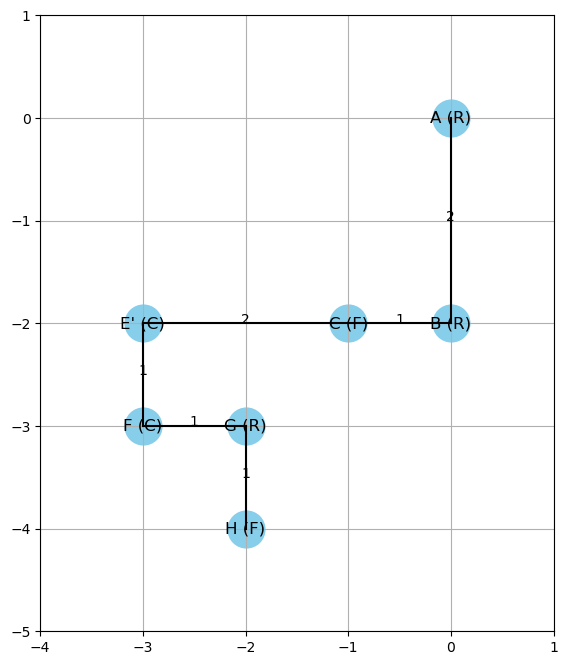

In [ ]:
def reduction_3(graph):
    paths=find_paths_with_rccc(graph)
    for path in paths:
        print(paths)
        direction_u3_u4=wg.get_edge(path[3],path[4]).direction
        
        weight_u3_u4=wg.get_edge(path[3],path[4]).weight
        

        direction_u4_u5=wg.get_edge(path[4],path[5]).direction
        
        weight_u4_u5=wg.get_edge(path[4],path[5]).weight
        
        weight_u2_u3=wg.get_edge(path[2],path[3]).weight
        

        graph.vertices[path[2]].angle_type='F'

        wg.remove_vertex(path[3])
        wg.remove_vertex(path[4])
        new_label=path[4]+"'"
        wg.add_vertex(new_label,'C')
        wg.add_edge(new_label,path[5],max(1,weight_u4_u5-weight_u2_u3),direction_u4_u5)
        wg.add_edge(path[2],new_label,weight_u3_u4,direction_u3_u4)
        wg.get_edge(path[0],path[1]).weight=max(weight_u2_u3,wg.get_edge(path[0],path[1]).weight)

reduction_3(wg)
wg.draw_graph()


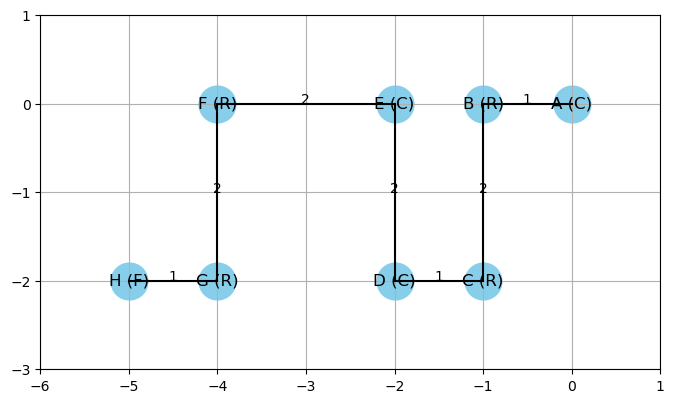

['A', 'B', 'C', 'D', 'E', 'F', 'G']


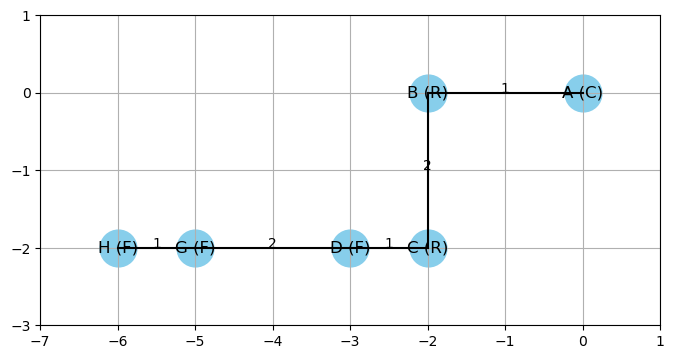

In [ ]:
def find_paths_with_rccr(graph):
    def dfs(current_vertex, path):
        if len(path) == 7:
            if (len(path) == 7 and
                graph.vertices[path[2]].angle_type == 'R' and
                graph.vertices[path[3]].angle_type == 'C' and
                graph.vertices[path[4]].angle_type == 'C' and
                graph.vertices[path[5]].angle_type == 'R'
                ):
                paths.append(path[:])
            return
        
        if current_vertex in graph.vertices:
            for neighbor in graph.vertices[current_vertex].edges:
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()

    paths = []
    for vertex in graph.vertices:
        dfs(vertex, [vertex])
    return paths


def reduction_4(graph):
    paths=find_paths_with_rccr(graph)
    for path in paths:
        print(path)
        direction_u3_u4=wg.get_edge(path[4],path[5]).direction
        weight_u3_u4=wg.get_edge(path[4],path[5]).weight
        weight_u2_u3=wg.get_edge(path[3],path[4]).weight

        wg.remove_vertex(path[4])
        wg.remove_vertex(path[5])

        wg.add_edge(path[3],path[6],weight_u3_u4,direction_u3_u4)
        wg.get_edge(path[0],path[1]).weight=max(wg.get_edge(path[0],path[1]).weight,weight_u2_u3)
        wg.update_vertex_angle_type(path[3],'F')
        wg.update_vertex_angle_type(path[5],'F')




# as we use vertex map so there are potential issues so fixing that 
wg=WeightedGraph()
wg.add_vertex('A', 'C')
wg.add_vertex('B', 'R')
wg.add_vertex('C', 'R')
wg.add_vertex('D', 'C')
wg.add_vertex('E', 'C')
wg.add_vertex('F', 'R')
wg.add_vertex('G', 'R')
wg.add_vertex('H', 'F')

wg.add_edge('A','B',1,'W')
wg.add_edge('B','C',2,'S')
wg.add_edge('C','D',1,'W')
wg.add_edge('D','E',2,'N')
wg.add_edge('E','F',2,'W')
wg.add_edge('F','G',2,'S')
wg.add_edge('G','H',1,'W')

wg.draw_graph()
reduction_4(wg)
wg.draw_graph()


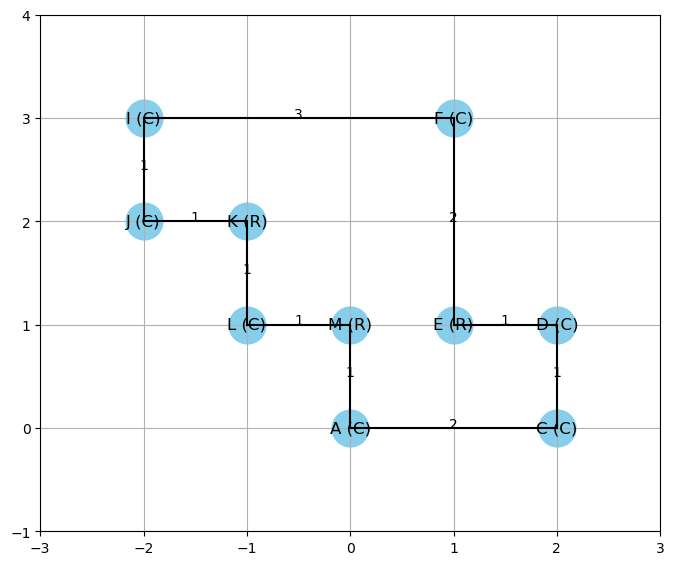

[['A', 'C', 'D', 'E', 'F'], ['C', 'D', 'E', 'F', 'I'], ['D', 'E', 'F', 'I', 'J'], ['E', 'F', 'I', 'J', 'K'], ['F', 'I', 'J', 'K', 'L'], ['I', 'J', 'K', 'L', 'M'], ['J', 'K', 'L', 'M', 'A'], ['K', 'L', 'M', 'A', 'C'], ['L', 'M', 'A', 'C', 'D'], ['M', 'A', 'C', 'D', 'E']]


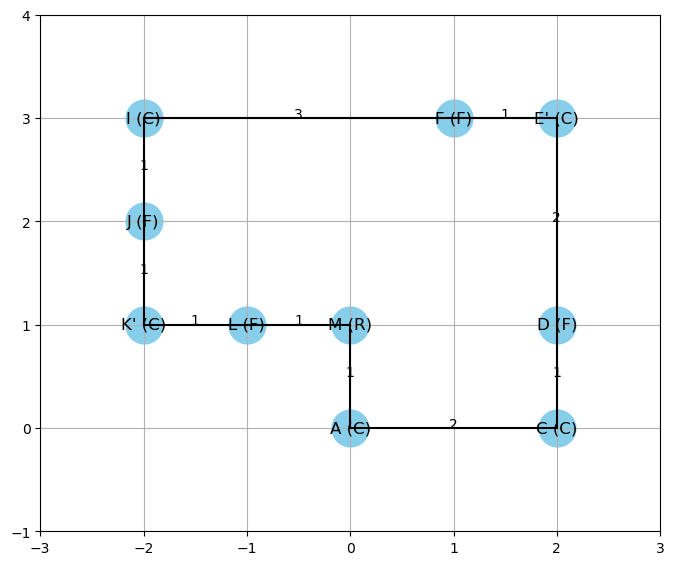

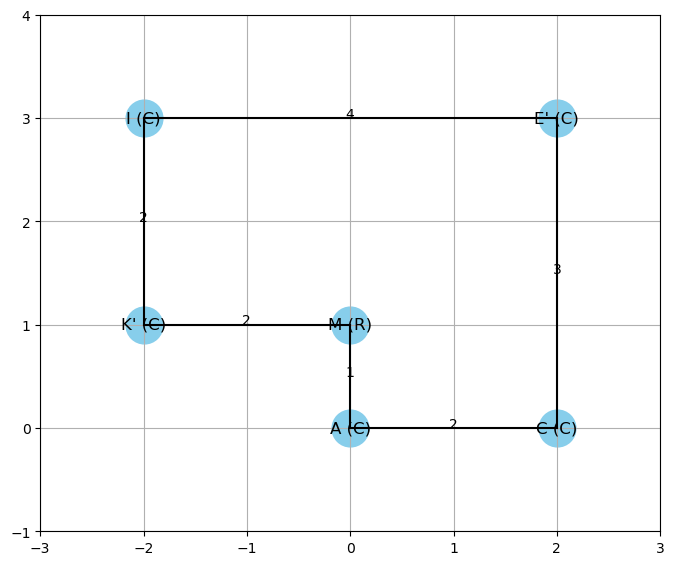

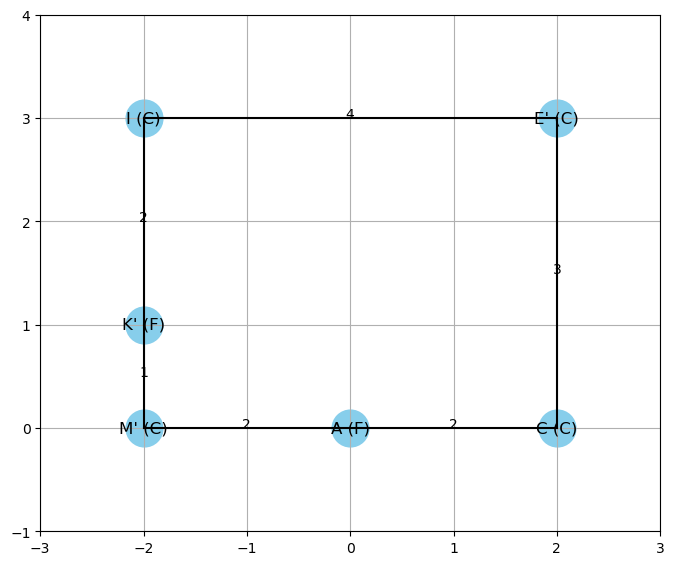

Vertex: C, Angle Type: C, Edges: E (weight: 3, N)
Vertex: E, Angle Type: C, Edges: I (weight: 4, W)
Vertex: I, Angle Type: C, Edges: M (weight: 3, S)
Vertex: M, Angle Type: C, Edges: C (weight: 4, E)


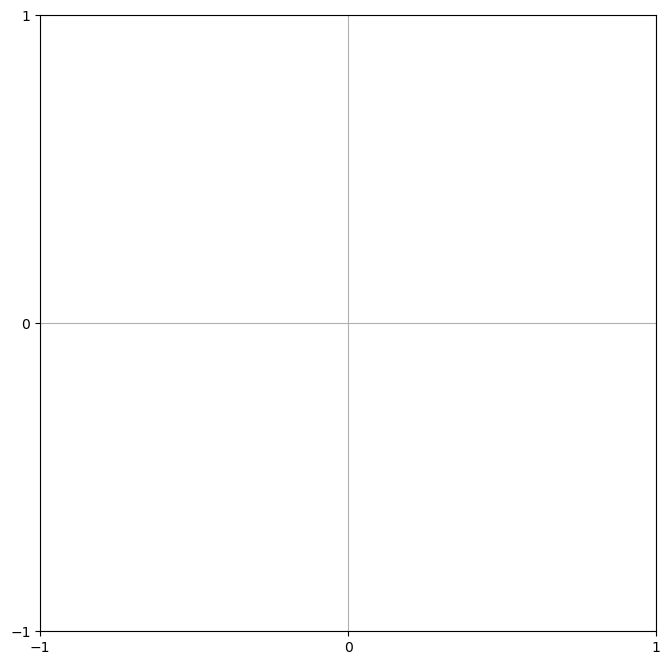

In [ ]:
def find_paths_with_crc(graph):
    def dfs(current_vertex, path):
        if len(path) == 5:
            paths.append(path[:])
            return

        if current_vertex in graph.vertices:
            for neighbor in graph.vertices[current_vertex].edges:
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()

    paths = []
    for vertex in graph.vertices:
        dfs(vertex, [vertex])
    return paths


def swap_edge_properties(edge1, edge2):
    edge1_weight = edge1.weight
    edge1_direction = edge1.direction
    edge1_length = edge1.length

    edge2_weight = edge2.weight
    edge2_direction = edge2.direction
    edge2_length = edge2.length

    edge1.weight = edge2_weight
    edge1.direction = edge2_direction
    edge1.length = edge2_length

    edge2.weight = edge1_weight
    edge2.direction = edge1_direction
    edge2.length = edge1_length


def reduction_5(graph):
    paths = find_paths_with_crc(graph)
    
    for path in paths:
        if (all(node in graph.vertices for node in path) and
            graph.vertices[path[1]].angle_type == 'C' and
            graph.vertices[path[2]].angle_type == 'R' and
            graph.vertices[path[3]].angle_type == 'C'):

            u2 = path[1]
            u3 = path[2]
            u4 = path[3]
            
            graph.update_vertex_angle_type(u2, 'F')
            graph.update_vertex_angle_type(u3, 'C')
            graph.update_vertex_angle_type(u4, 'F')
            
            graph.vertices[u3].label = f"{u3}'"

            edge_u2_u3 = graph.vertices[u2].edges[u3]
            edge_u3_u4 = graph.vertices[u3].edges[u4]
            swap_edge_properties(edge_u2_u3, edge_u3_u4)





wg= WeightedGraph()
wg.add_vertex('A', 'C')
wg.add_vertex('B', 'F')
wg.add_vertex('C', 'C')
wg.add_vertex('D', 'C')
wg.add_vertex('E', 'R')
wg.add_vertex('F', 'C')
wg.add_vertex('G', 'F')
wg.add_vertex('H', 'F')
wg.add_vertex('I', 'C')
wg.add_vertex('J', 'C')
wg.add_vertex('K', 'R')
wg.add_vertex('L', 'C')
wg.add_vertex('M', 'R')

wg.add_edge('A','B',1,'E')
wg.add_edge('B','C',1,'E')
wg.add_edge('C','D',1,'N')
wg.add_edge('D','E',1,'W')
wg.add_edge('E','F',2,'N')
wg.add_edge('F','G',1,'W')
wg.add_edge('G','H',1,'W')
wg.add_edge('H','I',1,'W')
wg.add_edge('I','J',1,'S')
wg.add_edge('J','K',1,'E')
wg.add_edge('K','L',1,'S')
wg.add_edge('L','M',1,'E')
wg.add_edge('M','A',1,'S')




reduction1(wg)
wg.draw_graph()
print(find_paths_with_crc(wg))
reduction_5(wg)
wg.draw_graph()
reduction1(wg)
wg.draw_graph()
reduction_5(wg)
wg.draw_graph()

reduction1(wg)
wg.print_graph()



